In [48]:
import os

notebook_path=os.getcwd()
print(notebook_path)

C:\Users\Administrator


In [3]:
import pandas as pd
import pytz

#creating a function to make it easy to read the data

def wrangle(filepath):
    
#reading the data from a CSV file into a dataframe
    df= pd.read_csv(filepath)
    
#splitting the data into 8 different columns as separated by semicolons

    df[["sensor_id", "sensor_type", "location","lat", "lon", "timestamp", "value_type", "value"]]= df["sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value"].str.split(";", expand=True)

    print("initial dataframe", df.head())
    
 #masking the data frame to obtain only PM2.5 readings
    
    mask_valuetype= df["value_type"]=="P2"
    
    df=df[mask_valuetype]
    
    print("after masking the dataframe", df.head())
       
#drop the long str colum
    df.drop(columns=["sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value"], inplace=True)
    
    print("After dropping columns", df.head())
    
#the columns needed are timestamp, value_type, and value

    df.drop(columns=["sensor_id", "sensor_type", "location", "lat", "lon"], inplace=True)
    
#dropping the value_type column since the df is already masked to PM2.5 values

    df.drop(columns=["value_type"], inplace=True)
    
#changing the datatypes of the columns
    
    df["timestamp"]=pd.to_datetime(df["timestamp"])
    
    df["value"]= df["value"].astype(float)
    
    print("after chaning data types", df.info())

#setting the index of the dataframe to timestamp
    df['timestamp'] = pd.to_datetime(df['timestamp'])
     
    df["timestamp"]=df.set_index('timestamp', inplace=True)
    
    print("After setting the timestamp:\n", df.head())
    
#resampling the data to a 1 hr window

    df=df["value"].resample("1H").mean().fillna(method="ffill").to_frame()
    
    print("After the resample:\n", df.head())
    
    #df["timestamp"]=df["timestamp"].tz_localize("UTC").tz_convert("Africa/Lagos")
    
#creating a lag column to analyze correlation
    df["value2"]=df["value"].shift(1)

#dropping the null row created by shifting the values by 1
 
    df.dropna(inplace=True)
    

    return df

df= wrangle(r"C:\Users\Administrator\OneDrive\WAIGURU\DataAnalysisProjects\Lagos Air Quality\sensor_data_1123.csv")
df.head()


initial dataframe   sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value sensor_id  \
0  4856;DHT22;3629;6.428;3.435;2023-11-01T16:44:1...                     4856   
1  4856;DHT22;3629;6.428;3.435;2023-11-01T16:44:1...                     4856   
2  4855;pms5003;3629;6.428;3.435;2023-11-01T16:44...                     4855   
3  4855;pms5003;3629;6.428;3.435;2023-11-01T16:44...                     4855   
4  4855;pms5003;3629;6.428;3.435;2023-11-01T16:44...                     4855   

  sensor_type location    lat    lon                         timestamp  \
0       DHT22     3629  6.428  3.435  2023-11-01T16:44:12.409509+00:00   
1       DHT22     3629  6.428  3.435  2023-11-01T16:44:12.409509+00:00   
2     pms5003     3629  6.428  3.435  2023-11-01T16:44:52.764459+00:00   
3     pms5003     3629  6.428  3.435  2023-11-01T16:44:52.764459+00:00   
4     pms5003     3629  6.428  3.435  2023-11-01T16:44:52.764459+00:00   

    value_type  value  
0     humidity  82.60  
1 

,value,value2
timestamp,,
2023-11-01 17:00:00+00:00,3.25,19.00
2023-11-01 18:00:00+00:00,40.33,3.25
2023-11-01 19:00:00+00:00,40.33,40.33
2023-11-01 20:00:00+00:00,40.33,40.33
2023-11-01 21:00:00+00:00,40.33,40.33


In [4]:
#reading several csv files into a single dataframe using pattern matching
from glob import glob

#using glob to obtain matched datasets

'''Use the r before the filepath to avoid getting a unicode error'''

files= glob(r"C:\Users\Administrator\Downloads\sensor_data_*.csv")
print("The files in the folder are:\n", len(files))

#using the wrangle function above to read all the files into a frames list

frames=[]
for file in files:
    df= wrangle(file)
    frames.append(df)
    
print("The Frames list is:\n", frames)

#use concat to read the data into a single dataframe

df= pd.concat(frames)
print("After combining the frames:\n", len(df))

#checking if there are any null values
df.isnull().sum()    

'''There are no null values'''

#checking the length of the dataframe...36489











The files in the folder are:
 5
initial dataframe   sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value sensor_id  \
0  4855;pms5003;3629;6.428;3.435;2024-01-01T00:31...                     4855   
1  4855;pms5003;3629;6.428;3.435;2024-01-01T00:31...                     4855   
2  4855;pms5003;3629;6.428;3.435;2024-01-01T00:31...                     4855   
3  4855;pms5003;3629;6.428;3.435;2024-01-01T00:37...                     4855   
4  4855;pms5003;3629;6.428;3.435;2024-01-01T00:37...                     4855   

  sensor_type location    lat    lon                         timestamp  \
0     pms5003     3629  6.428  3.435  2024-01-01T00:31:56.569920+00:00   
1     pms5003     3629  6.428  3.435  2024-01-01T00:31:56.569920+00:00   
2     pms5003     3629  6.428  3.435  2024-01-01T00:31:56.569920+00:00   
3     pms5003     3629  6.428  3.435  2024-01-01T00:37:01.145977+00:00   
4     pms5003     3629  6.428  3.435  2024-01-01T00:37:01.145977+00:00   

  value_type  valu

'There are no null values'

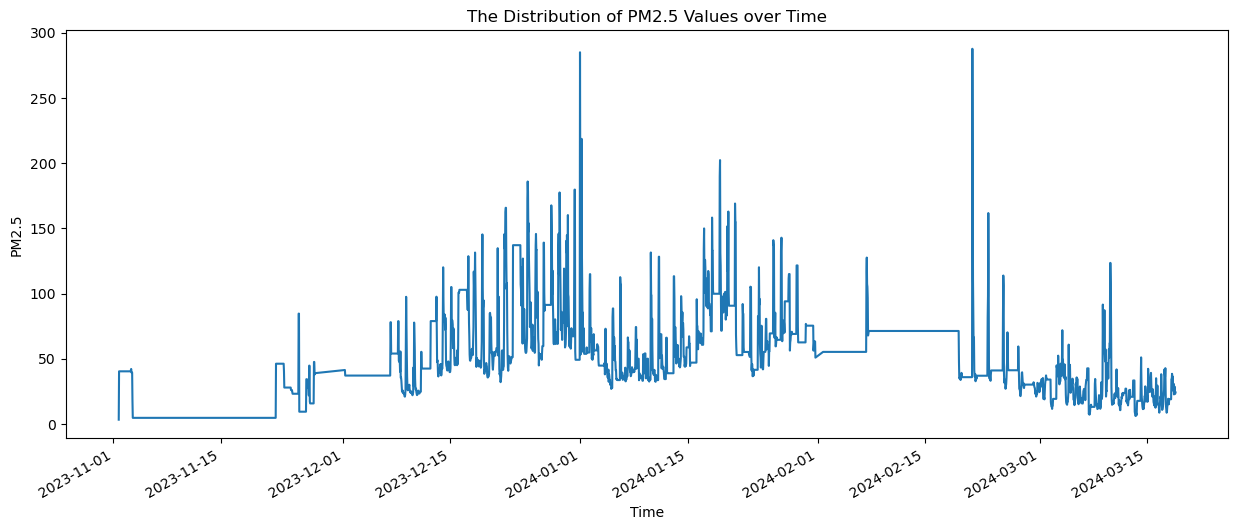

In [5]:
#visualizing PM2.5 readings
import matplotlib.pyplot as plt

fig, ax= plt.subplots(figsize=(15,6))
df["value"].plot(x="timestamp", y="value", xlabel="Time", ylabel="PM2.5", title="The Distribution of PM2.5 Values over Time", ax=ax)
plt.show()



In [6]:
print(df.head())

                                value      value2
timestamp                                        
2024-01-01 01:00:00+00:00   53.300000   52.875000
2024-01-01 02:00:00+00:00   58.000000   53.300000
2024-01-01 03:00:00+00:00  113.722222   58.000000
2024-01-01 04:00:00+00:00  218.625000  113.722222
2024-01-01 05:00:00+00:00  130.807500  218.625000


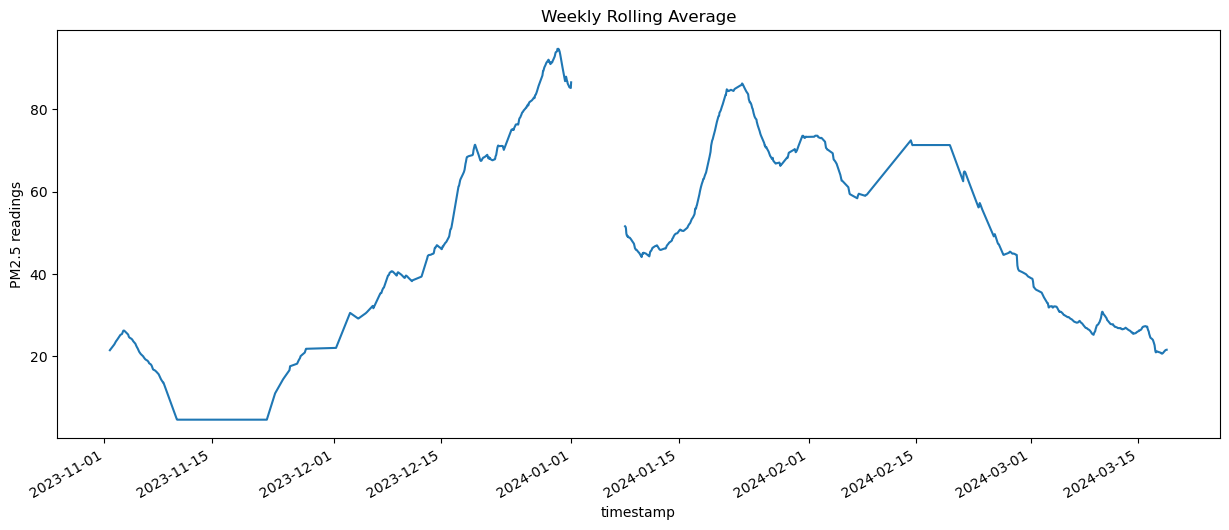

In [7]:
#plotting the rolling average for the week
fig, ax= plt.subplots(figsize=(15,6))
df["value"].rolling (168).mean().plot(ax=ax, ylabel="PM2.5 readings", title="Weekly Rolling Average");



In [8]:
#checking how the data is correlated

correlation= df.corr()
print("The correlation of the data is as follows:\n", correlation)

The correlation of the data is as follows:
            value    value2
value   1.000000  0.907576
value2  0.907576  1.000000


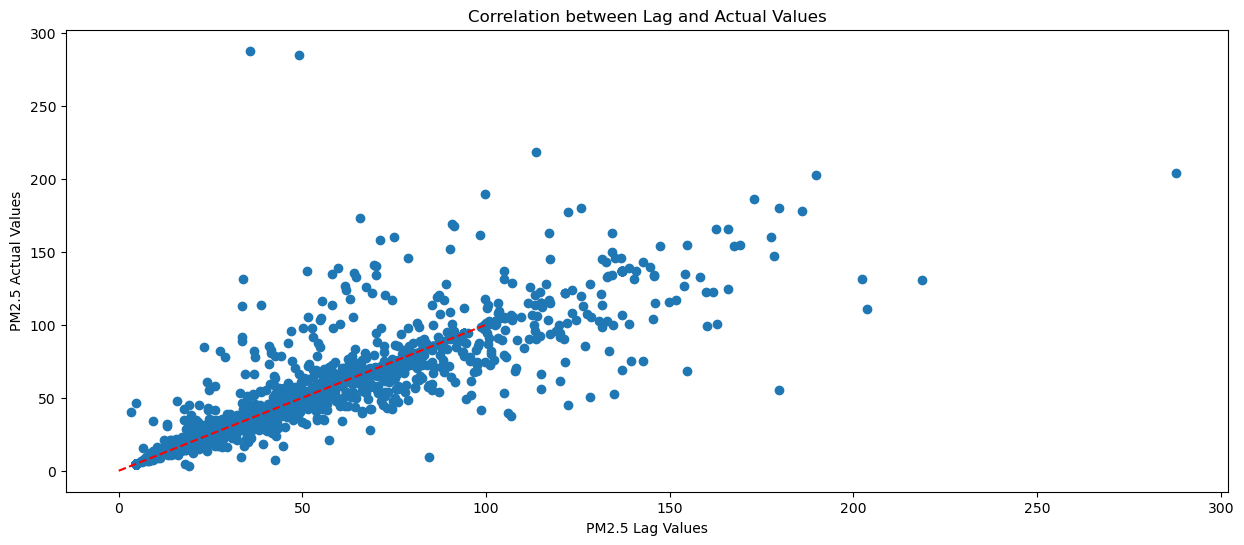

In [11]:
#creating a scatter plot to visualize the relationship between the lag and actual valules
fig, ax= plt.subplots(figsize=(15,6))
ax.scatter(x=df["value2"], y=df["value"])
plt.plot([0,100], [0,100], linestyle="--", color="red")
plt.xlabel("PM2.5 Lag Values")
plt.ylabel("PM2.5 Actual Values")
plt.title("Correlation between Lag and Actual Values")
plt.show()